In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display 
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [6]:
labels =[]
paths = []
for dirname, _, filenames in os.walk('TESS_Speech_Emotion_Dataset/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1] 
        label = label.split('.')[0]
        labels.append(label.lower())
print('dataset loading complete')    

dataset loading complete


In [7]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [8]:
#creating a data frame
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,TESS_Speech_Emotion_Dataset/tess toronto emoti...,angry
1,TESS_Speech_Emotion_Dataset/tess toronto emoti...,angry
2,TESS_Speech_Emotion_Dataset/tess toronto emoti...,angry
3,TESS_Speech_Emotion_Dataset/tess toronto emoti...,angry
4,TESS_Speech_Emotion_Dataset/tess toronto emoti...,angry


In [34]:
df['label'].value_counts()

angry      800
sad        800
happy      800
fear       800
neutral    800
ps         800
disgust    800
Name: label, dtype: int64

## Data Analysis 

<AxesSubplot:xlabel='label', ylabel='count'>

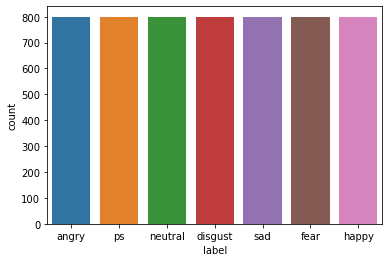

In [35]:
#If all are same , no need to class balancing
sns.countplot(df['label']) 


In [36]:
#display waveform & spectogram
def waveplot(data, srate, emotion):
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=srate)
    plt.show()
    
def spectogram(data, srate, emotion):
    x= librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(12,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=srate, x_axis='time', y_axis='hz')
    plt.colorbar()

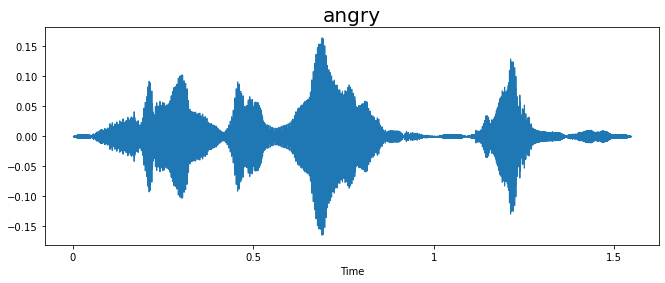

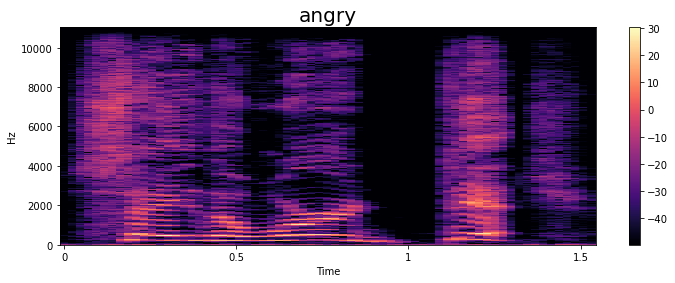

In [37]:

emotion='angry'
path=np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate =librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

Audio(path)

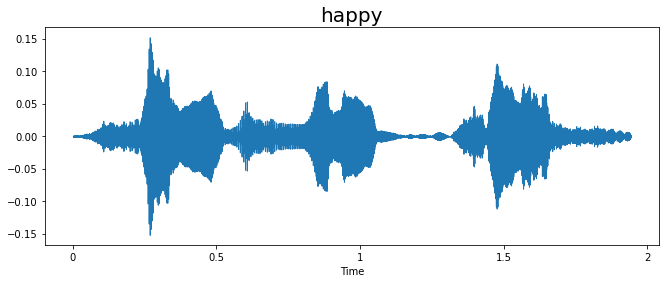

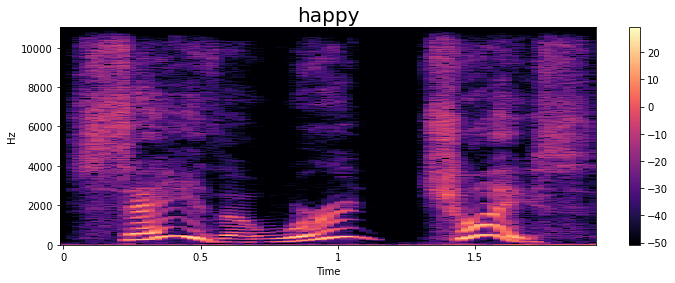

In [36]:
emotion='happy'
path=np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate =librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

Audio(path)

 ## Feature Extraction

In [30]:
#feature extraction using MFCC-
def feature_extraction_MFCC(filename):
    d, srate = librosa.load(filename, duration=2.5, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(d, sr=srate, n_mfcc=40), axis=1)
    return mfcc

In [14]:
d2, sr = librosa.load(df['speech'][0], duration=2.5, offset=0.5)
mfcc= librosa.feature.mfcc(d2, sr=sr, n_mfcc=13, n_fft=512, hop_length=1024)

In [15]:
mfcc.shape

(13, 23)

In [32]:
feature_extraction_MFCC(df['speech'][100]).shape

(40,)

In [40]:
X_mfcc= df['speech'].apply(lambda x: feature_extraction_MFCC(x))

In [44]:
#X-mfcc is in dataframe structure.. convert it into 2D array
X=[x for x in X_mfcc]
np.array(X).shape

(5600, 40)

In [45]:
# for LSTM model we have to expand 1 dimension
X = np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [46]:
#label_map = {label: num for num, label in enumerate(df['label'])}
emotions=['angry' , 'ps', 'neutral', 'disgust', 'sad', 'fear', 'happy']
label_map = {label: num for num, label in enumerate(emotions)}
label_map

{'angry': 0,
 'ps': 1,
 'neutral': 2,
 'disgust': 3,
 'sad': 4,
 'fear': 5,
 'happy': 6}

In [47]:
#one hot encoding of labels
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(df[['label']]).toarray())
y=enc_df.to_numpy()
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [48]:
#train set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

## Creating Model

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2022-03-29 22:07:22.322716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sherlock/catkin_ws/devel/lib:/opt/ros/noetic/lib
2022-03-29 22:07:22.322785: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [50]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(40,1))) #X.shape[1:2]
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(enc_df.shape[1], activation='softmax'))

2022-03-29 22:07:27.448849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sherlock/catkin_ws/devel/lib:/opt/ros/noetic/lib
2022-03-29 22:07:27.448919: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-29 22:07:27.448962: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jahid): /proc/driver/nvidia/version does not exist


In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 2

In [112]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size= 128, shuffle=True)

Epoch 1/100
42/42 [==============================] - 16s 282ms/step - loss: 1.5033 - categorical_accuracy: 0.4096
Epoch 2/100
42/42 [==============================] - 12s 296ms/step - loss: 0.8917 - categorical_accuracy: 0.6942
Epoch 3/100
42/42 [==============================] - 11s 254ms/step - loss: 0.3942 - categorical_accuracy: 0.8741
Epoch 4/100
42/42 [==============================] - 10s 242ms/step - loss: 0.1965 - categorical_accuracy: 0.9436
Epoch 5/100
42/42 [==============================] - 10s 244ms/step - loss: 0.2119 - categorical_accuracy: 0.9453
Epoch 6/100
42/42 [==============================] - 10s 241ms/step - loss: 0.1510 - categorical_accuracy: 0.9581
Epoch 7/100
42/42 [==============================] - 11s 261ms/step - loss: 0.0989 - categorical_accuracy: 0.9718
Epoch 8/100
42/42 [==============================] - 11s 251ms/step - loss: 0.1138 - categorical_accuracy: 0.9682
Epoch 9/100
42/42 [==============================] - 10s 244ms/step - loss: 0.0801 - cat

In [113]:
model.save('audio_emotion_classifier.h5')

## Confusion Matrix & Accuracy

In [115]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
y_pred = model.predict(X_test)

ytrue= np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(y_pred, axis=1).tolist()


In [116]:
multilabel_confusion_matrix(ytrue, y_pred)

array([[[239,   0],
        [  0,  41]],

       [[240,   0],
        [  0,  40]],

       [[236,   0],
        [  0,  44]],

       [[238,   0],
        [  0,  42]],

       [[238,   0],
        [  0,  42]],

       [[234,   0],
        [  0,  46]],

       [[255,   0],
        [  0,  25]]])

In [1]:
accuracy_score(ytrue, y_pred)

NameError: name 'accuracy_score' is not defined

In [25]:
paths = ('OAF_back_angry.wav')

In [26]:
v_mfcc= feature_extraction_MFCC(paths)


In [27]:
mod= model.load('audio_emotion_classifier.h5')

NameError: name 'model' is not defined